# Process Experiment Data

### Data Structures

In [265]:
import numpy as np

class Data:
    def __init__(self, params, loss, completion):
        self.params = params
        self.loss = np.array(loss, float)
        self.completion = np.array(completion, float)
        
    def __str__(self):
        return f"Params: ({self.params})" + \
            f", Loss: {self.loss[-1]:0.000}, Completion: {self.completion[-1]:0.000}"

class Params:
    def __init__(self, agents, radius, hazard, seed):
        self.agents = agents
        self.radius = radius
        self.hazard = hazard
        self.map = seed
    
    def __str__(self):
        if self.map is not None:
            return f"Agents: {self.agents}, Radius: {self.radius}" + \
                    f", Hazard: {self.hazard}, Map: {self.map}"
        else:
            return f"Agents: {self.agents}, Radius: {self.radius}" + \
                    f", Hazard: {self.hazard}"

### Parameter Combinations

In [242]:
import numpy as np

param_agents = [20, 50, 100]
marker_size = np.arange(1,7,1)
haz_fill = [.1, .25, .4]
seed = np.arange(1,101,1)

combinations = []
for a in param_agents:
    for s in seed:
        for h in haz_fill:
            for m in marker_size:
                p = Params(a, m, h, s)
                combinations.append(p)
print(f"{len(combinations)} parameter combinations.")

5400 parameter combinations.


### Import Data

In [253]:
import pandas as pd
import csv

data = []

# Import csv data
param_index = 0
for agent in param_agents:
    with open(r"data/" + str(agent) + " dead_data.csv", "r") as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            losses = np.array(row, float) / agent
            data.append(Data(combinations[param_index], losses, []))
            param_index += 1

param_index = 0
for agent in param_agents:
    with open(r"data/" + str(agent) + " explored_data.csv", "r") as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            data[param_index].completion = np.array(row, float)
            param_index += 1
print(f"{len(data)} entries.")
print("Example:")
print(data[100])

5400 entries.
Example:
Params: (Agents: 20, Radius: 5, Hazard: 0.25, Map: 6), Loss: 0.8, Completion: 0.6


### Process Data

Fill all missing data for experiments that completed early.

In [254]:
num_samples = 1001
for i, entry in enumerate(data):
    loss = entry.loss[-1]
    completion = entry.completion[-1]
    entry.loss = np.pad(entry.loss, 
                        (0, num_samples - len(entry.loss)),
                        'constant', constant_values=loss)
    entry.completion = np.pad(entry.completion, 
                              (0, num_samples - len(entry.completion)), 'constant',
                              constant_values=completion)

Average data for maps.

In [266]:
# Define function to compare parameter sets
def param_compare(a, b):
    same_agents = a.agents == b.agents
    same_haz = a.hazard == b.hazard
    same_rad = a.radius == b.radius
    return same_agents and same_haz and same_rad

# Get all map independent parameter sets
parameters = []
for a in param_agents:
    for h in haz_fill:
        for m in marker_size:
            p = Params(a, m, h, None)
            parameters.append(p)

# Average each parameter set
avg_data = []
for params in parameters:
    avg_loss = np.average(
        np.array([x.loss for x in data if param_compare(x.params, params)], float), 0)
    avg_comp = np.average(
        np.array([x.completion for x in data if param_compare(x.params, params)], float), 0)
    avg = Data(params, avg_loss, avg_comp)
    avg_data.append(avg)
    
print(f"{len(avg_data)} averaged entries.")

54 averaged entries.


### Visualization

Plot the loss and completion over time for a single averaged experiment.

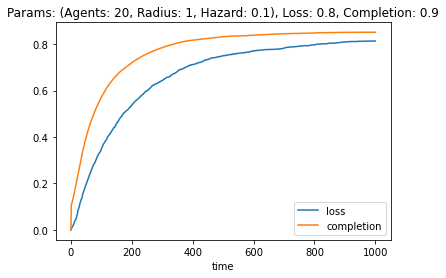

In [267]:
import matplotlib.pyplot as plt

# Plot loss and completion over time
t = np.arange(0, 1001, 1)
def plot_entry(entry, title=None):
    plt.plot(t, entry.loss, label = "loss")
    plt.plot(t, entry.completion, label = "completion")
    plt.xlabel('time')
    plt.title(str(entry))
    plt.legend()
    plt.show()

# Show example
plot_entry(avg_data[0])

Plot marker radius vs completion and loss for various numbers of agents for medium hazard fill.

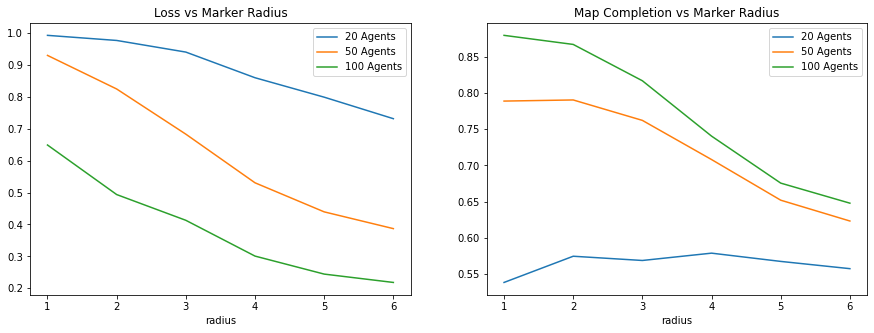

In [289]:
import matplotlib.pyplot as plt

# Get final loss and completion for each marker radius
agent_loss = []
agent_completion = []

for i, agent in enumerate(param_agents):
    agent_loss.append([])
    agent_completion.append([])
    for radius in marker_size:
        search = Params(agent, radius, 0.25, None)
        agent_loss[i].append([x.loss for x in avg_data if param_compare(x.params, search)][0][-1])
        agent_completion[i].append([x.completion for x in avg_data if param_compare(x.params, search)][0][-1])

# Show plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((15,5))
ax1.plot(marker_size, agent_loss[0], label = "20 Agents")
ax1.plot(marker_size, agent_loss[1], label = "50 Agents")
ax1.plot(marker_size, agent_loss[2], label = "100 Agents")
ax1.set_xlabel('radius')
ax1.set_title("Loss vs Marker Radius")
ax1.legend()
ax2.plot(marker_size, agent_completion[0], label = "20 Agents")
ax2.plot(marker_size, agent_completion[1], label = "50 Agents")
ax2.plot(marker_size, agent_completion[2], label = "100 Agents")
ax2.set_xlabel('radius')
ax2.set_title("Map Completion vs Marker Radius")
ax2.legend()

Plot marker radius vs completion and loss for various hazard levels using 50 agents.

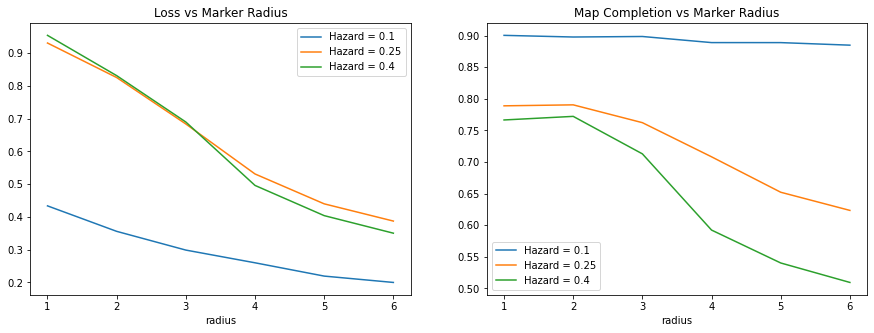

In [291]:
import matplotlib.pyplot as plt

# Get final loss and completion for each marker radius
haz_loss = []
haz_completion = []

for i, haz in enumerate(haz_fill):
    haz_loss.append([])
    haz_completion.append([])
    for radius in marker_size:
        search = Params(50, radius, haz, None)
        haz_loss[i].append([x.loss for x in avg_data if param_compare(x.params, search)][0][-1])
        haz_completion[i].append([x.completion for x in avg_data if param_compare(x.params, search)][0][-1])

# Show plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((15,5))
ax1.plot(marker_size, haz_loss[0], label = "Hazard = 0.1")
ax1.plot(marker_size, haz_loss[1], label = "Hazard = 0.25")
ax1.plot(marker_size, haz_loss[2], label = "Hazard = 0.4")
ax1.set_xlabel('radius')
ax1.set_title("Loss vs Marker Radius")
ax1.legend()
ax2.plot(marker_size, haz_completion[0], label = "Hazard = 0.1")
ax2.plot(marker_size, haz_completion[1], label = "Hazard = 0.25")
ax2.plot(marker_size, haz_completion[2], label = "Hazard = 0.4")
ax2.set_xlabel('radius')
ax2.set_title("Map Completion vs Marker Radius")
ax2.legend()